# Visualizing a Bike Ride in 3D

Will Geary ([@wgeary](http://www.twitter.com/wgeary))

This notebook will walk through the steps necessary to use [Cesium](http://www.cesiumjs.org), a JavaScript library for 3D mapping, to visualize GPX data recorded with [Strava](http://www.strava.com/).

Below is what the result looks like. Live version here: https://willgeary.github.io/CesiumApps/Apps/Strava/

In [1]:
import IPython
url = 'https://willgeary.github.io/CesiumApps/Apps/Strava/'
iframe = '<iframe src=' + url + ' width=100% height=600></iframe>'
IPython.display.HTML(iframe)

# About CZML

Cesium defines a JSON data format called [CZML](https://github.com/AnalyticalGraphicsInc/czml-writer/wiki/CZML-Guide) for describing a time-dynamic graphical scenes, primarily for display in a web browser running Cesium. It describes lines, points, polygons, models, and other graphical primitives, and specifies how they change with time. The relationship between Cesium and CZML is similar to the relationship between Google Earth and KML. 

CZML is an attractive paradigm for descriping spatio-temporal data. In particular, it proposes the following format for describing three-dimensional positions that change over time:


[CartographicValue](https://github.com/AnalyticalGraphicsInc/czml-writer/wiki/CartographicValue): A geodetic, WGS84 position specified as [Longitude, Latitude, Height]. If the array has three elements, the value is constant. If it has four or more elements, they are time-tagged samples arranged as [Time, Longitude, Latitude, Height, Time, Longitude, Latitude, Height, ...], where Time is an ISO 8601 date and time string or seconds since epoch.

For example, the following array specifies the [Long, Lat, Height] of an entity at 0 seconds since epoch, 1 second since epoch and 2 seconds since epoch:

[
0, -77, 37, 100000,

1, -77.5, 37, 100500,

2, -77.9, 37, 100900
]

# GPX + CZML = 3D Awesomeness

This notebook will walk through the following steps: 

1. Read and parse GPX data 
2. Use GPX data to generate CZML data
3. Visualize CZML data with CesiumJS

# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import gpxpy
import json

# Read GPX File

I used [Strava](http://www.strava.com/) to record a recent bike ride around the Ashokan Reservoir near Woodstock, NY. We will visualize the GPX file that was exported from Strava.

In [3]:
gpx_file = open('../data/Woodstock_NY.gpx', 'r')
gpx = gpxpy.parse(gpx_file)

# Parse GPX File

Extract latitudes, longitudes, elevations and timestamps from GPX file and throw it into a dataframe.

In [4]:
## See a primer on reading GPX data in python here: http://andykee.com/visualizing-strava-tracks-with-python.html

def parse_gpx(gpx_input_file):
    
    lats = []
    lons = []
    elevations = []
    timestamps = []

    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                lats.append(point.latitude)
                lons.append(point.longitude)
                elevations.append(point.elevation)
                timestamps.append(point.time)
                   
    output = pd.DataFrame()
    output['latitude'] = lats
    output['longitude'] = lons
    output['elevation'] = elevations
    output['starttime'] = timestamps
    output['stoptime'] = output['starttime'].shift(-1).fillna(method='ffill')
    output['duration'] = (output['stoptime'] - output['starttime']) / np.timedelta64(1, 's') ## duration to seconds
    
    return output

Here's what the GPX data looks like after we parse it:

In [5]:
df = parse_gpx(gpx)
df.head()

,latitude,longitude,elevation,starttime,stoptime,duration
0,42.029884,-74.107225,162.0,2017-06-11 19:51:59,2017-06-11 19:52:03,4.0
1,42.029855,-74.107269,163.0,2017-06-11 19:52:03,2017-06-11 19:52:05,2.0
2,42.029824,-74.107292,163.4,2017-06-11 19:52:05,2017-06-11 19:52:12,7.0
3,42.029788,-74.107308,163.4,2017-06-11 19:52:12,2017-06-11 19:52:20,8.0
4,42.029826,-74.107312,163.4,2017-06-11 19:52:20,2017-06-11 19:52:22,2.0


# Generate CZML Path

Create an array to describe three-dimensional position over time: [timestep, long, lat, elevation, ...]

In [6]:
def create_czml_path(df_input, relative_elevation = False):
    results = []
    
    timestep = 0
    
    for i in df_input.index:
        results.append(timestep)
        results.append(df_input.longitude.ix[i])
        results.append(df_input.latitude.ix[i])
        
        if relative_elevation == True:
            results.append(30) # for use with point = {"heightReference" : "RELATIVE_TO_GROUND"}
        else:
            results.append(df_input.elevation.ix[i])
        
        duration = df_input.duration.ix[(i)]
        timestep += duration
        
    return results

Here is what the first few positions look like on our path:

In [7]:
create_czml_path(df)[:12]

[0,
 -74.107225,
 42.029884000000003,
 162.0,
 4.0,
 -74.107269000000002,
 42.029854999999998,
 163.0,
 6.0,
 -74.107292000000001,
 42.029823999999998,
 163.40000000000001]

# Generate CZML Document

Now we need to create the entire CZML document, which will include the CZML path from above. See documenation [here](https://github.com/AnalyticalGraphicsInc/czml-writer/wiki/CZML-Guide).

In [8]:
def point_with_trailing_path(df_input, time_multiplier = 1000):
    
    # Store output in array
    czml_output = []

    # Define global variables
    global_id = "document"
    global_name = "Visualizing GPX Data from Strava"
    global_version = "1.0"
    global_author = "Will Geary"
    global_starttime = str(min(df_input['starttime'])).replace(" ", "T").replace(".000", "Z")
    global_stoptime = str(max(df_input['stoptime'])).replace(" ", "T").replace(".000", "Z")
    global_availability = global_starttime + "/" + global_stoptime    
    
    # Create packet with global variables
    global_element = {
        "id" : global_id,
        "name" : global_name,
        "version" : global_version,
        "author": global_author,
        "clock": {
            "interval": global_availability,
            "currentTime": global_starttime,
            "multiplier": time_multiplier
        }
    }
    
    # Append global packet to output
    czml_output.append(global_element)
    
    # Define path variables
    path_id = "path"
    path_starttime = str(min(df_input['starttime'])).replace(" ", "T").replace(".000", "Z")
    path_stoptime = str(max(df_input['starttime'])).replace(" ", "T").replace(".000", "Z")
    path_availability = path_starttime + "/" + path_stoptime
    
    # Create path object
    path_object = {
            "id": path_id,

            "availability": path_availability,

            "position": {
                "epoch": path_starttime,
                "cartographicDegrees": create_czml_path(df, relative_elevation=False)
            },

            "path" : {
                "material" : {
                    "polylineOutline" : {
                        "color" : {
                            "rgba" : [255,255,255, 200]
                        },
                        "outlineColor" : {
                            "rgba" : [0,173,253, 200]
                        },
                        "outlineWidth" : 5
                    }
                },
                "width" : 6,
                "leadTime" : 0,
                "trailTime" : 100000,
                "resolution" : 5
            }
        }

    # Append path element to output
    czml_output.append(path_object)
        
    # Define point variable
    point_id = "Point"
    point_starttime = str(min(df_input['starttime'])).replace(" ", "T").replace(".000", "Z")
    point_stoptime = str(max(df_input['starttime'])).replace(" ", "T").replace(".000", "Z")
    point_availability = point_starttime + "/" + point_stoptime
    
    point_object = {
            "id": point_id,

            "availability": point_availability,

            "position": {
                "epoch": point_starttime,
                "cartographicDegrees": create_czml_path(df, relative_elevation=True)
            },

            "point": {
                "color": {
                    "rgba": [255, 255, 255, 255]
                },
                "outlineColor": {
                    "rgba": [0,173,253, 255]
                },
                "outlineWidth":6,
                "pixelSize":8,
                "heightReference" : "RELATIVE_TO_GROUND"
            }   
        }

    czml_output.append(point_object)
    
    return czml_output

Save output to czml file.

In [9]:
czml_output = point_with_trailing_path(df)

with open('/Users/Will/node_modules/Cesium-1.33/Apps/Data/woodstock.czml', 'w') as outfile:
    json.dump(czml_output, outfile)

# Visualize with Cesium

Below is what my result looks like (allow a few seconds to load). Full screen version here: https://willgeary.github.io/CesiumApps/Apps/Strava/

In [10]:
import IPython
url = 'https://willgeary.github.io/CesiumApps/Apps/Strava/'
iframe = '<iframe src=' + url + ' width=100% height=600></iframe>'
IPython.display.HTML(iframe)

I created the above visualization using CesiumJS locally. But you can test yours out online without having to download Cesium by using Cesium's Sandbox tool.

To visualize your data online:

1. Navigate to: http://cesiumjs.org/Cesium/Apps/Sandcastle/index.html?src=CZML%20Path.html&label=

2. Open the CZML output file created above and copy its contents

3. Paste CZML contents into the sidebar in place of existing czml variable

4. Click `Run`

You should get something like this:

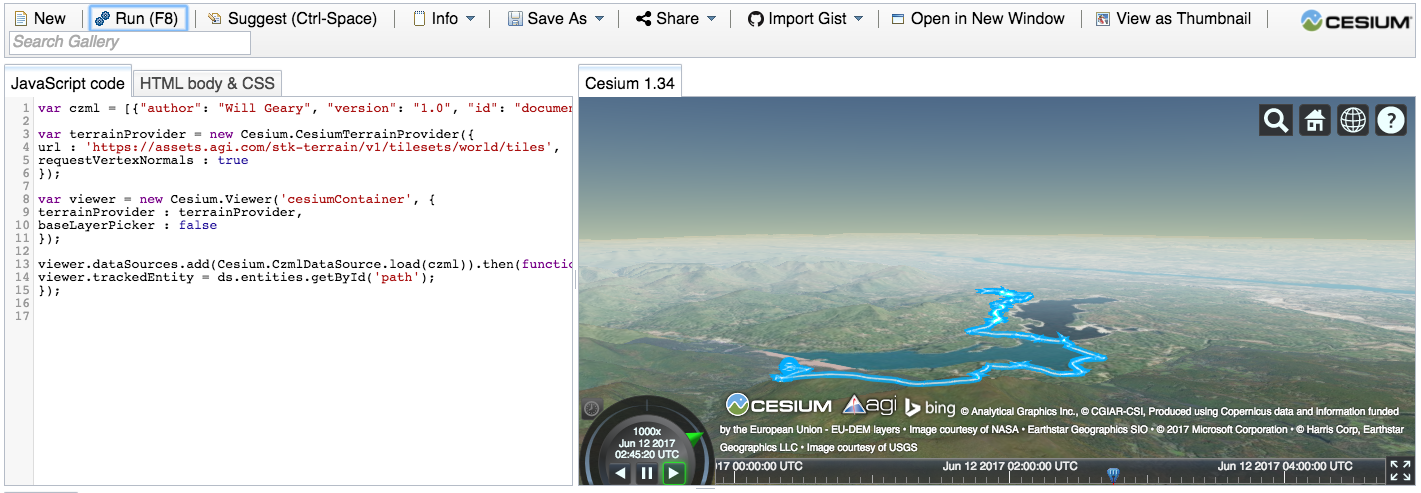

In [12]:
from IPython.display import Image
Image('../images/screenshot.png')